# Imports

In [1]:
import os
import pathlib
import random
import sys
from pathlib import __file__

import matplotlib.pyplot as plt
import tensorflow as tf

sys.dont_write_bytecode = True

sys.path.insert(0, pathlib.Path().absolute().parent.parent.parent.__str__())
sys.path.append(os.path.join(os.path.dirname(__file__), "../../../../src"))

from LSC_recognizer_model.src.pixels.data.data_aug import DataAug
from LSC_recognizer_model.src.pixels.data.split_dataset import SplitDataset
from LSC_recognizer_model.src.utils.sign_dataset import (PATH_PROCESSED_DATA, PATH_RAW_DATA, SignDataset)

In [2]:
path_raw_data = '../../data/raw/Signs_prueba'
path_process_data = '../../data/processed/Signs_prueba'

# 1. Capa Split Dataset (Train, Validation y Test)

In [3]:
# Forma #1: Coger un dataset ya existente (puede ser el obtenido en la capa de dataaug)
splitDataset = SplitDataset(porcentage_train=0.8, porcentage_test=0.1, porcentage_validation=0.1, defined_dataset=tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))
dataset_train, dataset_test, dataset_validation = splitDataset.get_datasets()

In [4]:
# Forma #2: Abrir el dataset desde los archivos (los .jpg)
splitDataset = SplitDataset(porcentage_train=0.8, porcentage_test=0.1, porcentage_validation=0.1, path=path_raw_data)
raw_ds_train, raw_ds_test, raw_ds_validation = splitDataset.get_datasets()

In [5]:
len(raw_ds_train), len(raw_ds_test), len(raw_ds_validation)

(208, 26, 26)

# 2. Capa Data Augmentation

## 2.1. Transformaciones Individuales
Se debe crear una lista de tuplas donde el primer valor es la cantidad de imagenes a generar con esta transformación y el segundo valor es la transformación a aplicar. (num_images, transform).

Esta transformación duplica el dataset y aplica la transformación a cada imagen, para posteriormente concatenar el dataset original con el dataset transformado. Todo este proceso se hace por cada transformación de la lista.

In [6]:
def flip(image, label):
    return tf.image.flip_left_right(image), label

def random_rotation(image, label):
    transformation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.12),
    ])
    image = transformation(image)
    image = tf.cast(image,tf.uint8)
    return image, label

def zoom(image, label):
    transformation = tf.keras.Sequential([
        tf.keras.layers.RandomZoom(0.2, 0.2),
    ])
    image = transformation(image)
    image = tf.cast(image,tf.uint8)
    return image, label

single_transformations = [
    (1, zoom),
    (1, flip),
    (1, random_rotation)
]

## 2.2. Transformaciones Separadas
Se debe crear una lista de tuplas donde el primer valor es la cantidad de imagenes a generar con esta transformación y el segundo valor es la transformación a aplicar. (num_images, transform).

Esta transformación duplica el dataset y aplica la transformación a cada imagen, para posteriormente concatenar el dataset original con el dataset transformado. A diferencia de las transformaciones individuales, esta transformación no coge las otras transformaciones que estan en la lista.

In [7]:
def random_brightness(image, label):
    seed = random.randrange(0, 100)
    image = tf.image.random_brightness(image, max_delta=0.65, seed=seed)
    return image, label

def random_contrast(image, label):
    seed = random.randrange(0, 100)
    image = tf.image.random_contrast(image, lower=0.3, upper=0.7, seed=seed)
    return image, label

separeted_transformations = [
    (1, random_brightness),
    (1, random_contrast)
]


## 2.3. Transformaciones Generales
Se debe crear una lista de tuplas donde el primer valor es la cantidad de imagenes a generar con esta transformación y el segundo valor es la transformación a aplicar. (num_images, transform).

Esta transformación no duplica el dataset sino que pasa encima del dataset original haciendo la transformación implementada.

In [8]:
def transformation(image, label):
    transformation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.12), # maximum degrees of rotation
    ])
    return transformation(image), label

general_transformation = transformation

## 2.4. Uso clase para DataAug

In [9]:
# Forma #1: Abrir el dataset desde los archivos (los .jpg)
dataAug = DataAug(
    path=path_raw_data, 
    normalize_images=False,
    single_transformations=single_transformations, 
    general_transformation=general_transformation
)
dataset_aug = dataAug.generate_data_aug()

In [10]:
# Forma #2: Coger un dataset ya existente (puede ser el obtenido en la capa de dataaug)
#dataAug = DataAug(path=path_raw_data, normalize_images=True, single_transformations=single_transformations, general_transformation=general_transformation, defined_dataset=raw_ds_train)
dataAug = DataAug(
    defined_dataset=raw_ds_train, 
    normalize_images=False,
    single_transformations=single_transformations,
    separeted_transformations=separeted_transformations,
    general_transformation=general_transformation
)
dataset_aug = dataAug.generate_data_aug()

In [11]:
len(dataset_aug)

1248

## 2.5 Guardar las fotos del data augmentation en una carpeta

In [12]:
#data_aug.save_dataset_jpg(dataset=dataset_aug, path_to_save=path_process_data)

# 3. Capa Dataset

## 3.1 Crear capa de dataset y generar dataset train, validation, test

In [13]:
# Forma #1: Abrir el dataset desde los archivos (los .jpg)
signDatasetTrain = SignDataset(path=path_raw_data, shuffle=False)
dataset_train = signDatasetTrain.get_dataset()

In [14]:
# Forma #2: Coger un dataset ya existente (puede ser el obtenido en la capa de dataaug)
signDatasetTrain = SignDataset(path=path_raw_data, defined_dataset=dataset_aug, shuffle=False, resize_images=True, normalize_images=True)
dataset_train = signDatasetTrain.get_dataset()

In [15]:
signDatasetValidation = SignDataset(defined_dataset=raw_ds_validation, shuffle=False, disable_repeate=True, resize_images=True)
dataset_validation = signDatasetValidation.get_dataset()

signDatasetTest = SignDataset(defined_dataset=raw_ds_test, shuffle=False, disable_repeate=True, resize_images=True)
dataset_test = signDatasetTest.get_dataset()

Shape of the image: (TensorShape([32, 256, 256, 3]),)
Shape of the label: (32, 2)
Image : [[[0.69411767 0.69411767 0.654902  ]
  [0.8745098  0.85882354 0.8156863 ]
  [0.77254903 0.77254903 0.73333335]
  ...
  [0.25882354 0.26666668 0.39215687]
  [0.2627451  0.22745098 0.2901961 ]
  [0.3019608  0.23529412 0.22745098]]

 [[0.7176471  0.7176471  0.6784314 ]
  [0.7490196  0.7490196  0.70980394]
  [0.64705884 0.64705884 0.60784316]
  ...
  [0.18039216 0.22352941 0.3529412 ]
  [0.23137255 0.21960784 0.27450982]
  [0.28235295 0.22745098 0.22745098]]

 [[0.69803923 0.69803923 0.65882355]
  [0.70980394 0.70980394 0.67058825]
  [0.7058824  0.7058824  0.6666667 ]
  ...
  [0.20392157 0.22745098 0.3529412 ]
  [0.20392157 0.17254902 0.24705882]
  [0.2784314  0.23137255 0.23137255]]

 ...

 [[0.18431373 0.18039216 0.16470589]
  [0.14117648 0.13725491 0.12156863]
  [0.21960784 0.21176471 0.21568628]
  ...
  [0.29411766 0.3137255  0.25882354]
  [0.80784315 0.7921569  0.7411765 ]
  [0.81960785 0.8078431

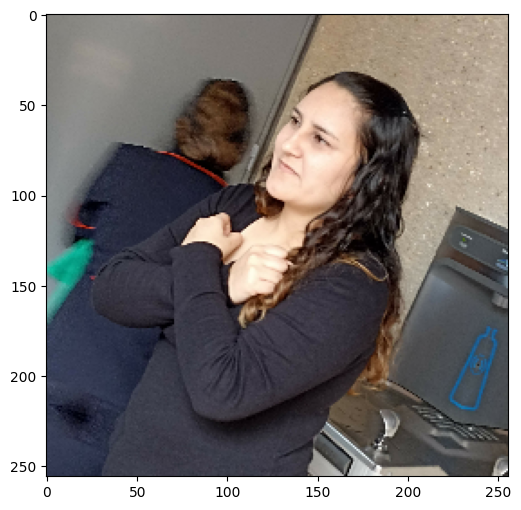

In [16]:
one_batch = dataset_train.take(2)
plt.figure(figsize=(6, 6))
for i, l in one_batch:
  print(f"Shape of the image: {i.shape,}")
  print(f"Shape of the label: {l.shape}")
  print(f"Image : {i[0]}")
  print(f"Label: {l[0]}")
  plt.imshow(i[0].numpy().astype("float32"))

# 4. Modelo ejemplo de la conexión

In [17]:
steps_per_epoch = signDatasetTrain.get_recomend_steps_per_epoch()
classes = signDatasetTrain.get_classes()
num_classes = len(classes)

Advertencia: se ingresó un dataset previamente creado, por lo cual las clases que se obtienen del path pueden no ser las correctas


In [18]:
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=model.input, outputs=predictions)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [20]:
model.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [21]:
print("Device used for training: {}".format(tf.test.gpu_device_name()))

Device used for training: /device:GPU:0


In [22]:
# Train the model (put the accuracy, val_accuracy, loss, val_loss metrics in the history)
history = model.fit(dataset_train, epochs=10, steps_per_epoch=steps_per_epoch, validation_data=dataset_validation)

Epoch 1/10
9/9 [==============================] - 118s 5s/step - loss: 1.0556 - accuracy: 0.6736 - val_loss: 389.3634 - val_accuracy: 0.5000
Epoch 2/10
9/9 [==============================] - 29s 4s/step - loss: 0.8418 - accuracy: 0.7639 - val_loss: 47901.4023 - val_accuracy: 0.5000
Epoch 3/10
9/9 [==============================] - 59s 7s/step - loss: 0.8233 - accuracy: 0.6944 - val_loss: 176447.6562 - val_accuracy: 0.5000
Epoch 4/10
9/9 [==============================] - 54s 6s/step - loss: 0.7335 - accuracy: 0.6458 - val_loss: 971147.2500 - val_accuracy: 0.5000
Epoch 5/10
9/9 [==============================] - 17s 1s/step - loss: 0.4815 - accuracy: 0.8125 - val_loss: 86743.3828 - val_accuracy: 0.5000
Epoch 6/10
9/9 [==============================] - 4s 504ms/step - loss: 0.4262 - accuracy: 0.8229 - val_loss: 541.1606 - val_accuracy: 0.5000
Epoch 7/10
9/9 [==============================] - 4s 440ms/step - loss: 0.3868 - accuracy: 0.8333 - val_loss: 1092.6917 - val_accuracy: 0.5000
Epoc

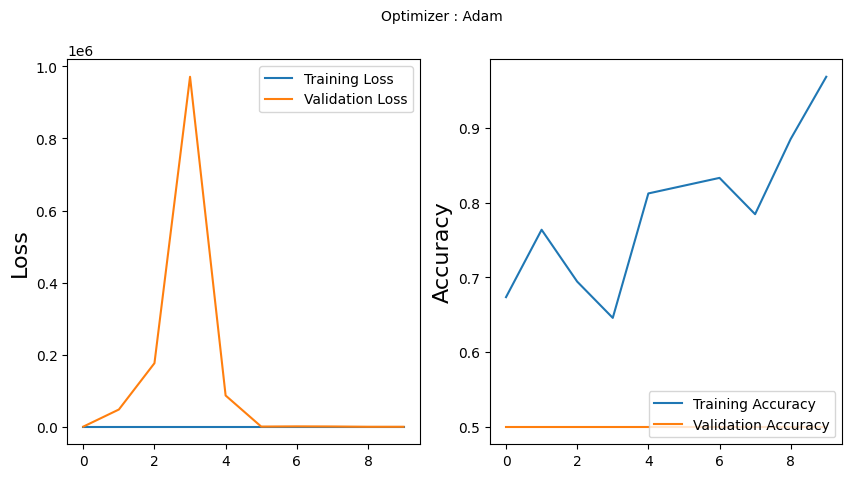

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()